# loading modules and pretrained neural network

In [8]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import PIL
from scipy.special import softmax

# load pretrained network
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

def load_image(image_location):
    x = np.asarray(PIL.Image.open(image_location))
    x = x.reshape(28,28)
    x = x.reshape(784, 1)
    x = x.astype('float32')
    x /= 255
    return x

# prediction function

In [14]:
# make prediction on input feature vector x and return the softmax result
def predict(net, x):
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')
    plt.imshow(x.reshape((28,28)), cmap='Greys')
    return softmax(net.feedforward(x))

# prediction demo

Network prediction: 2

Actual image: 


array([[0.08531952],
       [0.08531952],
       [0.23192219],
       [0.08531952],
       [0.08531952],
       [0.08531952],
       [0.08532645],
       [0.08551473],
       [0.08531952],
       [0.08531952]])

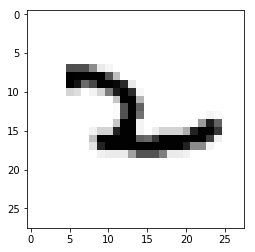

In [15]:
x = load_image('/Users/zetong/mnist_png/testing/2/1722.png')
predict(net, x)

# functions for creating adversarial examples
The attack is solving an optimization:
$$ min_{x} \quad \|\vec y_{goal} - y_{hat}(\vec x)\|^2_2 + \lambda \|\vec x - \vec x_{target}\|^2_2 $$

Function input_derivative is taking the gradient of output y with respect to the input x: $\frac{\partial y}{\partial x}$ for the particular neural network net.

Funtion targeted_attack finds the adversarial example x that would be misclassified by net as target label.

Function nontargeted_attack finds all the adversarial example with all possible misclassified labels

In [4]:
# sigmoid function
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
# derivative of sigmoid function                                                                                                                                                                                
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

# net: neural network object, target_label: target label, x_target: x feature vector, steps: gradient descent steps,
# eta: step size, lam: regularization constant
def targeted_attack(net, target_label, x_target, steps, eta, lam=0.05):    
    # Set the one-hot target output
    goal = np.zeros((10, 1))
    goal[target_label] = 1
    
    # gradient descent starting point
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # derivative
        d = input_derivative(net,x,goal)
        # gradient update
        x -= eta * (d + lam * (x - x_target))

    return x

# find all the possible mislabelling for input sample x_target
def nontargeted_attack(net, x_target, true_label, steps, eta, class_num, lam=0.05):
    attacks = []
    predicted_labels = []
    for i in range(class_num):
        goal = np.zeros((10, 1))
        goal[i] = 1

        # gradient descent starting point
        x = np.random.normal(.5, .3, (784, 1))

        # Gradient descent on the input
        for i in range(steps):
            # derivative
            d = input_derivative(net,x,goal)
            # gradient update
            x -= eta * (d + lam * (x - x_target))
        prediction = np.argmax(net.feedforward(x))
        if prediction != true_label:
            attacks.append(x)
            predicted_labels.append(prediction)
    return attacks, predicted_labels

# putting the adversarial examples and their misclassification labels in subplots
def plot_adversarials(attacks, predicted_labels):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text("Prediction: " + str(predicted_labels[i-1]))
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()

# wrapper function for creating adversarial examples
def attack(net, x, steps=10000, eta=0.1, lam=0.01):
    # number of classes
    class_num = net.sizes[-1]
    # true label
    true_label = np.argmax(net.feedforward(x))
    # get the adversarial examples and their respective misclassification labels
    attacks, predicted_labels = nontargeted_attack(net, x, true_label, steps, eta, class_num)
    plot_adversarials(attacks, predicted_labels)

# attack demo

Network prediction: 2

Actual image: 


array([[0.0854114 ],
       [0.08540737],
       [0.22763299],
       [0.08540737],
       [0.08540737],
       [0.0854075 ],
       [0.08910387],
       [0.08540737],
       [0.08540737],
       [0.08540737]])

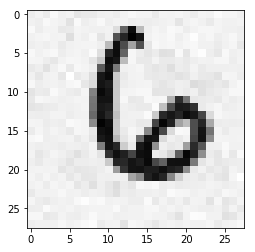

In [18]:
x = load_image('/Users/zetong/mnist_png/testing/6/88.png')
predict(net, targeted_attack(net, 2, x, 10000, 0.1))

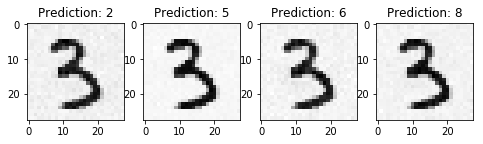

In [21]:
x = load_image('/Users/zetong/mnist_png/testing/3/32.png')
attacks, predicted_labels = nontargeted_attack(net, x, 3, 10000, 0.1, 10)
plot_adversarials(attacks, predicted_labels)

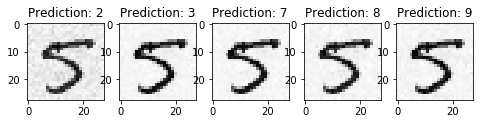

In [23]:
x = load_image('/Users/zetong/mnist_png/testing/5/102.png')
attack(net, x)